<h1 style="text-align: center">Toxic comments Prediction</h1>

#### Import the packages

In [57]:
import numpy as np
import pandas as pd
import json, nltk
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import seaborn as sns
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.metrics import log_loss
%matplotlib inline

In [59]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Function to calculate and print metrics for a given model
def print_metrics(model_name, y_true, y_pred):
    precision = precision_score(y_true, y_pred, zero_division=0)
    recall = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)
    
    print(f"{model_name} Metrics:")
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"F1 Score: {f1:.2f}")
    
    return precision, recall, f1

In [2]:
total_data = pd.read_csv("train.csv", encoding="ISO-8859-1")

##### Import [Contractions](https://stackoverflow.com/a/19794953/8141330)

In [3]:
with open('assets/contractions.json', 'r') as f:
    contractions_dict = json.load(f)
contractions = contractions_dict['contractions']

In [4]:
pd.set_option('display.max_colwidth', -1)

C:\Users\Kowshik Rayani\AppData\Local\Temp\ipykernel_17700\3652881321.py:1: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('display.max_colwidth', -1)


##### Printing the dataset

In [5]:
total_data.head()

,tweet,label
0,"Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27",0
1,"D'aww! He matches this background colour I'm seemingly stuck with. Thanks. (talk) 21:51, January 11, 2016 (UTC)",0
2,"Hey man, I'm really not trying to edit war. It's just that this guy is constantly removing relevant information and talking to me through edits instead of my talk page. He seems to care more about the formatting than the actual info.",0
3,"""\nMore\nI can't make any real suggestions on improvement - I wondered if the section statistics should be later on, or a subsection of """"types of accidents"""" -I think the references may need tidying so that they are all in the exact same format ie date format etc. I can do that later on, if no-one else does first - if you have any preferences for formatting style on references or want to do it yourself please let me know.\n\nThere appears to be a backlog on articles for review so I guess there may be a delay until a reviewer turns up. It's listed in the relevant form eg Wikipedia:Good_article_nominations#Transport """,0
4,"You, sir, are my hero. Any chance you remember what page that's on?",0


##### Taking column names into variables

In [6]:
tweet = total_data.columns.values[0]
sentiment = total_data.columns.values[1]
tweet, sentiment

('tweet', 'label')

In [7]:
total_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4044 entries, 0 to 4043
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   tweet   4044 non-null   object
 1   label   4044 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 63.3+ KB


<br/>

# 1)  Preprocessing

* **Convert every tweets to lower case**
* **Remove Twitter username**
* **Remove punctuations, numbers and special characters**
* **Convert more than 2 letter repetitions to 2 letter ( example (wooooooow --> woow))**
* **Remove extra spaces**
* **Remove URLs**
* **Emoji analysis**
* **Handle contractions words**
    - **" can't " >> " can not "**
    - **" won't " >> " will not "**
    - **" should't " >> " should not "**


##### A function for handling emoji classifications

In [8]:
import re
def emoji(tweet):
    tweet = re.sub(r'(:\s?\)|:-\)|\(\s?:|\(-:|:\'\)|:O)', ' positiveemoji ', tweet)
    tweet = re.sub(r'(:\s?D|:-D|x-?D|X-?D)', ' positiveemoji ', tweet)
    tweet = re.sub(r'(<3|:\*)', ' positiveemoji ', tweet)
    tweet = re.sub(r'(;-?\)|;-?D|\(-?;|@-\))', ' positiveemoji ', tweet)
    tweet = re.sub(r'(:\s?\(|:-\(|\)\s?:|\)-:|:-/|:-\|)', ' negetiveemoji ', tweet)
    tweet = re.sub(r'(:,\(|:\'\(|:"\()', ' negetiveemoji ', tweet)
    return tweet


In [9]:


def process_tweet(tweet):
    print(tweet)
    tweet = tweet.lower()                                             
    tweet = re.sub('@[^\s]+', '', tweet)                              
    tweet = re.sub('((www\.[^\s]+)|(https?://[^\s]+))', ' ', tweet)   
    tweet = re.sub(r"\d+", " ", str(tweet))                           
    tweet = re.sub('&quot;'," ", tweet)                               
    tweet = emoji(tweet)                                              
    tweet = re.sub(r"\b[a-zA-Z]\b", "", str(tweet))                   
    for word in tweet.split():
        if word.lower() in contractions:
            tweet = tweet.replace(word, contractions[word.lower()])   
    tweet = re.sub(r"[^\w\s]", " ", str(tweet))                       
    tweet = re.sub(r'(.)\1+', r'\1\1', tweet)                        
    tweet = re.sub(r"\s+", " ", str(tweet))                           
    return tweet

In [10]:
total_data[tweet]

0       Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       

###### Now make a new column for side by side comparison of new tweets vs old tweets

In [11]:
total_data['processed_tweet'] = np.vectorize(process_tweet)(total_data[tweet])

Explanation
Why the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27
Explanation
Why the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27
D'aww! He matches this background colour I'm seemingly stuck with. Thanks.  (talk) 21:51, January 11, 2016 (UTC)
Hey man, I'm really not trying to edit war. It's just that this guy is constantly removing relevant information and talking to me through edits instead of my talk page. He seems to care more about the formatting than the actual info.
"
More
I can't make any real suggestions on improvement - I wondered if the section statistics should be later on, or a sub

###### Let's compare unprocessed tweets with the processed one

In [12]:
total_data.head(10)

,tweet,label,processed_tweet
0,"Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27",0,explanation why the edits made under my username hardcore metallica fan were reverted they weren vandalisms just closure on some gas after voted at new york dolls fac and please don remove the template from the talk page since retired now
1,"D'aww! He matches this background colour I'm seemingly stuck with. Thanks. (talk) 21:51, January 11, 2016 (UTC)",0,aww he matches this background colour seemingly stuck with thanks talk january utc
2,"Hey man, I'm really not trying to edit war. It's just that this guy is constantly removing relevant information and talking to me through edits instead of my talk page. He seems to care more about the formatting than the actual info.",0,hey man really not trying to edit war it just that this guy is constantly removing relevant information and talking to me through edits instead of my talk page he seems to care more about the formatting than the actual info
3,"""\nMore\nI can't make any real suggestions on improvement - I wondered if the section statistics should be later on, or a subsection of """"types of accidents"""" -I think the references may need tidying so that they are all in the exact same format ie date format etc. I can do that later on, if no-one else does first - if you have any preferences for formatting style on references or want to do it yourself please let me know.\n\nThere appears to be a backlog on articles for review so I guess there may be a delay until a reviewer turns up. It's listed in the relevant form eg Wikipedia:Good_article_nominations#Transport """,0,more can make any real suggestions on improvement wondered if the section statistics should be later on or subsection of types of accidents think the references may need tidying so that they are all in the exact same format ie date format etc can do that later on if no one else does first if you have any preferences for formatting style on references or want to do it yourself please let me know there appears to be backlog on articles for review so guess there may be delay until reviewer turns up it listed in the relevant form eg wikipedia good_article_nominations transport
4,"You, sir, are my hero. Any chance you remember what page that's on?",0,you sir are my hero any chance you remember what page that on
5,"""\n\nCongratulations from me as well, use the tools well. Â Â· talk """,0,congratulations from me as well use the tools well â â talk
6,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,cocksucker before you piss around on my work
7,"Your vandalism to the Matt Shirvington article has been reverted. Please don't do it again, or you will be banned.",0,your vandalism to the matt shirvington article has been reverted please don do it again or you will be banned
8,"Sorry if the word 'nonsense' was offensive to you. Anyway, I'm not intending to write anything in the article(wow they would jump on me for vandalism), I'm merely requesting that it be more encyclopedic so one can use it for school as a reference. I have been to the selective breeding page but it's almost a stub. It points to 'animal breeding' which is a short messy article that gives you no info. There must be someone around with expertise in eugenics? 93.161.107.169",0,sorry if the word nonsense was offensive to you anyway not intending to write anything in the article wow they would jump on me for vandalism merely requesting that it be more encyclopedic so one can use it for school as reference have been to the selective breeding page but it almost stub it points to animal breeding which is short messy article that gives you no info there must be someone around with expertise in eugenics
9,alignment on this subject and which are contrary to those of DuLithgow

# 2) Most used words

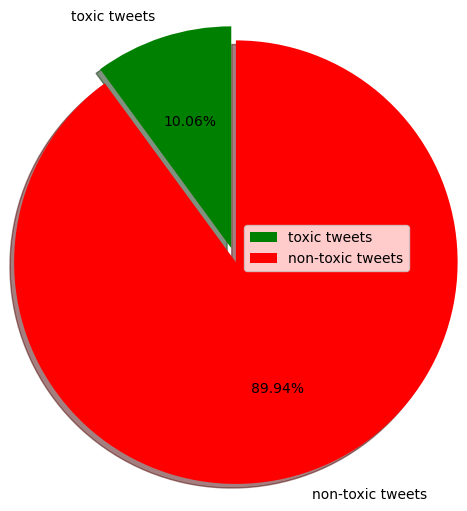

In [13]:
sentiments = ['toxic tweets', 'non-toxic tweets'] 
slices = [(total_data[sentiment] != 0).sum(), (total_data[sentiment] == 0).sum()] 
colors = ['g', 'r'] 
plt.pie(slices, labels = sentiments, colors=colors, startangle=90, shadow = True,
        explode = (0, 0.1), radius = 1.5, autopct = '%1.2f%%') 
plt.legend()
plt.show() 

# 3) Feature extraction (vectorization)

## 3.1) Count vectorizer

As we all know, all machine learning algorithms are good with numbers; we have to extract or convert the text data into numbers without losing much of the information. One way to do such transformation is *Bag-Of-Words (BOW)* which gives a number to each word but that is very inefficient. So, a way to do it is by *CountVectorizer*: it counts the number of words in the document i.e it converts a collection of text documents to a matrix of the counts of occurences of each word in the document.

In [14]:
from sklearn.feature_extraction.text import CountVectorizer

count_vectorizer = CountVectorizer(ngram_range=(1,2))    # Unigram and Bigram
final_vectorized_data = count_vectorizer.fit_transform(total_data['processed_tweet'])  
final_vectorized_data

<4044x148265 sparse matrix of type '<class 'numpy.int64'>'
	with 410561 stored elements in Compressed Sparse Row format>

## 3.2) Tf-Idf vectorizer

The below code is commented out because *CountVectorizer* gives better accuracy in this sentiment analysis than *tf-idf*. 
<br/>  


In [15]:
# from sklearn.feature_extraction.text import TfidfVectorizer 

# tf_idf_vectorizer = TfidfVectorizer(use_idf=True,ngram_range=(1,3))
# final_vectorized_data = tf_idf_vectorizer.fit_transform(total_data['processed_tweet'])

# final_vectorized_data

# 4) Splitting

##### Splitting train data to test accuracy

In [16]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(final_vectorized_data, total_data[sentiment],
                                                    test_size=0.2, random_state=69)  
print(y_train[0:10])

3827    0
459     0
2655    0
252     0
1291    1
1510    0
3103    0
2643    0
1384    0
3780    0
Name: label, dtype: int64


##### Printing splitted dataset sizes

In [17]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(final_vectorized_data, total_data[sentiment],
                                                    test_size=0.2, random_state=69)  
print(y_train[0:10])

X_train_shape :  (3235, 148265)
X_test_shape :  (809, 148265)
y_train_shape :  (3235,)
y_test_shape :  (809,)


# 5) Train and predict

#### We will use Random Forest, SVC, LR and KNN

In [60]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier()

# Training the classifier
clf.fit(X_train, y_train)
B_pred = clf.predict(X_test)
racc=clf.score(X_test, y_test)
rf_precision, rf_recall, rf_f1 = print_metrics('Random Forest Classifier', y_test, B_pred)
print('Accuracy: ',racc*100)
rf_log_loss = log_loss(y_test, clf.predict_proba(X_test))
print('Log Loss :', rf_log_loss)

Random Forest Classifier Metrics:
Precision: 1.00
Recall: 0.20
F1 Score: 0.34
Accuracy:  90.72929542645241
Log Loss : 0.23241676925780078


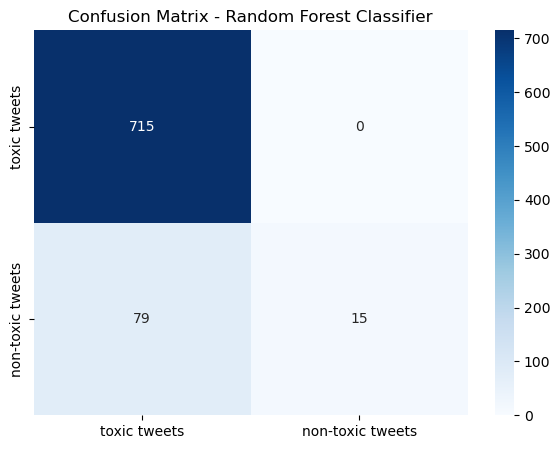

In [29]:
conf_matrix_rf = confusion_matrix(y_test, B_pred)
sns.heatmap(conf_matrix_rf, annot=True, fmt='d', cmap='Blues', xticklabels=sentiments, yticklabels=sentiments)
plt.title('Confusion Matrix - Random Forest Classifier')
plt.show()

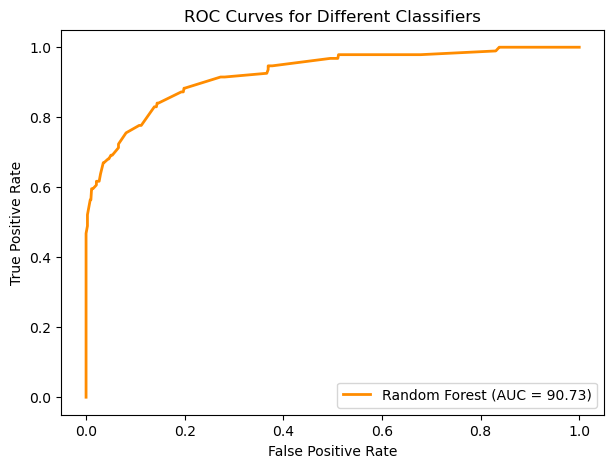

In [79]:
rf_auc = roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1])
fpr_rf, tpr_rf, _ = roc_curve(y_test, clf.predict_proba(X_test)[:, 1])
plt.plot(fpr_rf, tpr_rf, color='darkorange', lw=2, label='Random Forest (AUC = {:.2f})'.format(racc*100))
# plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Different Classifiers')
plt.legend()
plt.show()

In [61]:
from sklearn.svm import SVC
svcmodel=SVC(kernel='rbf', random_state=0,probability=True)
svcmodel.fit(X_train, y_train)
# predict probabilities
svcacc = svcmodel.score(X_test, y_test)
svc_precision, svc_recall, svc_f1 = print_metrics('Support Vector Classifier', y_test, svcmodel.predict(X_test))
print('Accuracy: ',svcacc*100 )
svc_log_loss = log_loss(y_test, svcmodel.predict_proba(X_test))
print('Log Loss :', svc_log_loss)

Support Vector Classifier Metrics:
Precision: 0.00
Recall: 0.00
F1 Score: 0.00
Accuracy:  88.38071693448703
Log Loss : 0.2100390264484057


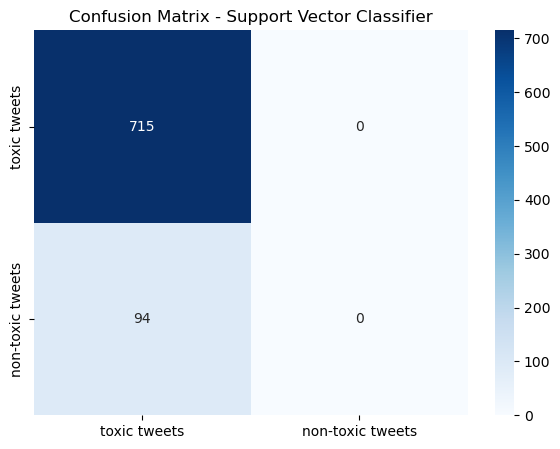

In [30]:
conf_matrix_svc = confusion_matrix(y_test, svcmodel.predict(X_test))
sns.heatmap(conf_matrix_svc, annot=True, fmt='d', cmap='Blues', xticklabels=sentiments, yticklabels=sentiments)
plt.title('Confusion Matrix - Support Vector Classifier')
plt.show()

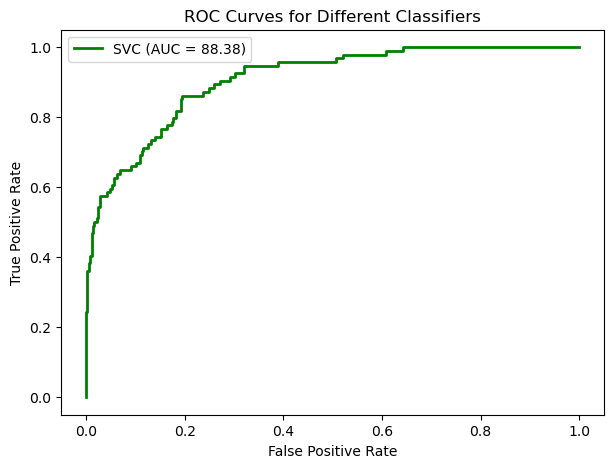

In [82]:
svc_auc = roc_auc_score(y_test, svcmodel.predict_proba(X_test)[:, 1])
fpr_svc, tpr_svc, _ = roc_curve(y_test, svcmodel.predict_proba(X_test)[:, 1])
plt.plot(fpr_svc, tpr_svc, color='green', lw=2, label='SVC (AUC = {:.2f})'.format(svcacc*100))
# plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Different Classifiers')
plt.legend()
plt.show()

In [62]:
from sklearn.linear_model import LogisticRegression
LRmodel = LogisticRegression(solver='lbfgs')
LRmodel.fit(X_train, y_train)
loacc=LRmodel.score(X_test, y_test)
lr_precision, lr_recall, lr_f1 = print_metrics('Logistic Regression', y_test, LRmodel.predict(X_test))
print('Accuracy: ',loacc*100) 
lr_log_loss = log_loss(y_test, LRmodel.predict_proba(X_test))
print('Log Loss :', lr_log_loss)

Logistic Regression Metrics:
Precision: 0.87
Recall: 0.41
F1 Score: 0.56
Accuracy:  92.45982694684795
Log Loss : 0.2345734512971924


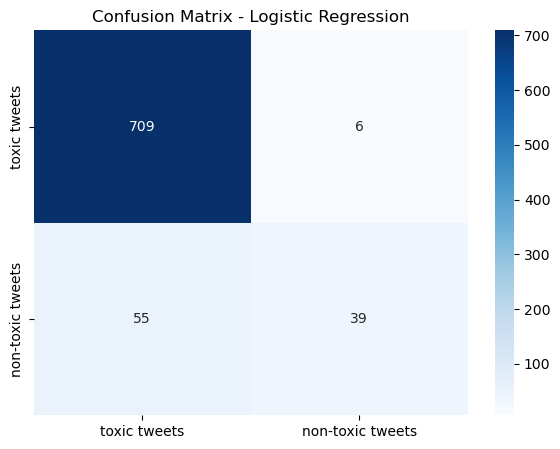

In [31]:
conf_matrix_lr = confusion_matrix(y_test, LRmodel.predict(X_test))
sns.heatmap(conf_matrix_lr, annot=True, fmt='d', cmap='Blues', xticklabels=sentiments, yticklabels=sentiments)
plt.title('Confusion Matrix - Logistic Regression')
plt.show()

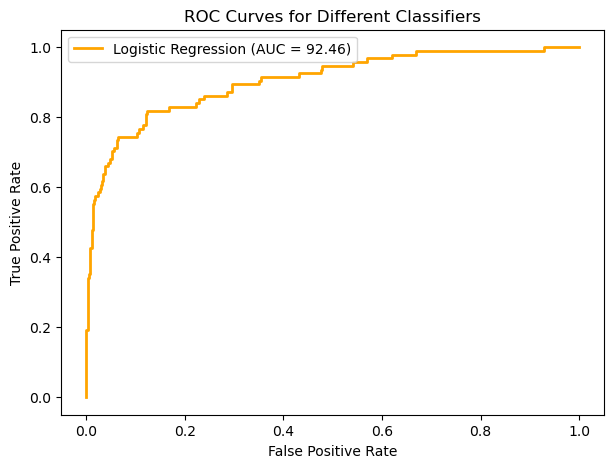

In [84]:
lr_auc = roc_auc_score(y_test, LRmodel.predict_proba(X_test)[:, 1])
fpr_lr, tpr_lr, _ = roc_curve(y_test, LRmodel.predict_proba(X_test)[:, 1])
plt.plot(fpr_lr, tpr_lr, color='orange', lw=2, label='Logistic Regression (AUC = {:.2f})'.format(loacc*100))
# plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Different Classifiers')
plt.legend()
plt.show()

In [66]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=9)
knn.fit(X_train,y_train)
knnacc=knn.score(X_test, y_test)
knn_precision, knn_recall, knn_f1 = print_metrics('K-Nearest Neighbors', y_test, knn.predict(X_test))
print('Accuracy: ',knnacc*100)
knn_log_loss = log_loss(y_test, knn.predict_proba(X_test))
print('Log Loss :', knn_log_loss)

K-Nearest Neighbors Metrics:
Precision: 0.75
Recall: 0.03
F1 Score: 0.06
Accuracy:  88.62793572311496
Log Loss : 1.4176267197837162


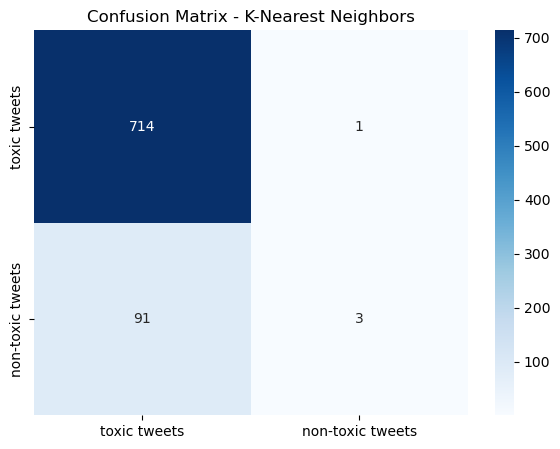

In [32]:
conf_matrix_knn = confusion_matrix(y_test, knn.predict(X_test))
sns.heatmap(conf_matrix_knn, annot=True, fmt='d', cmap='Blues', xticklabels=sentiments, yticklabels=sentiments)
plt.title('Confusion Matrix - K-Nearest Neighbors')
plt.show()

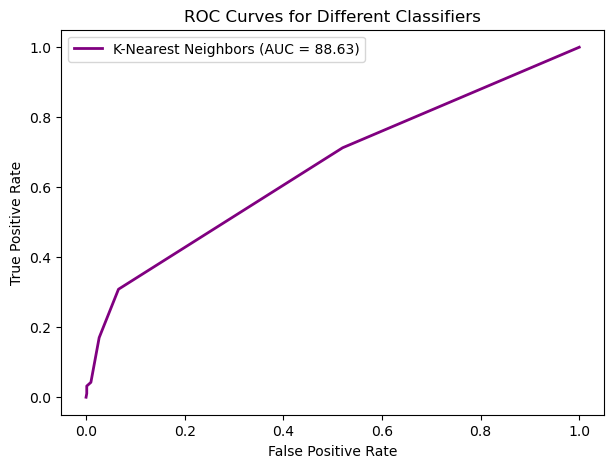

In [85]:
knn_auc = roc_auc_score(y_test, knn.predict_proba(X_test)[:, 1])
fpr_knn, tpr_knn, _ = roc_curve(y_test, knn.predict_proba(X_test)[:, 1])
plt.plot(fpr_knn, tpr_knn, color='purple', lw=2, label='K-Nearest Neighbors (AUC = {:.2f})'.format(knnacc*100))
# plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Different Classifiers')
plt.legend()
plt.show()

## Find out accuracy of our prediction

In [64]:
from sklearn.ensemble import VotingClassifier
#from sklearn.multiclass import OneVsRestClassifier
#create a dictionary of base learners
estimators=[('SVC',svcmodel),('LR', LRmodel),('rfc', clf)]
#create voting classifier
majority_voting = VotingClassifier(estimators, voting='soft')
#classifier = OneVsRestClassifier(majority_voting)
#fit model to training data
majority_voting.fit(X_train, y_train)
#test our model on the test data
vacc=majority_voting.score(X_test, y_test)
voting_precision, voting_recall, voting_f1 = print_metrics('Majority Voting Classifier', y_test, majority_voting.predict(X_test))
print("Accuracy of the Voting Ensemble: {:.2f}%".format(vacc*100))
voting_log_loss = log_loss(y_test, majority_voting.predict_proba(X_test))
print('Log Loss :', voting_log_loss)

Majority Voting Classifier Metrics:
Precision: 0.89
Recall: 0.36
F1 Score: 0.52
Accuracy of the Voting Ensemble: 92.09%
Log Loss : 0.20049653968308792


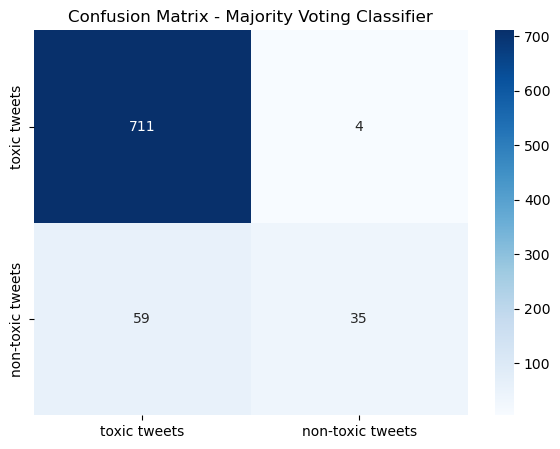

In [33]:
conf_matrix_voting = confusion_matrix(y_test, majority_voting.predict(X_test))
sns.heatmap(conf_matrix_voting, annot=True, fmt='d', cmap='Blues', xticklabels=sentiments, yticklabels=sentiments)
plt.title('Confusion Matrix - Majority Voting Classifier')
plt.show()

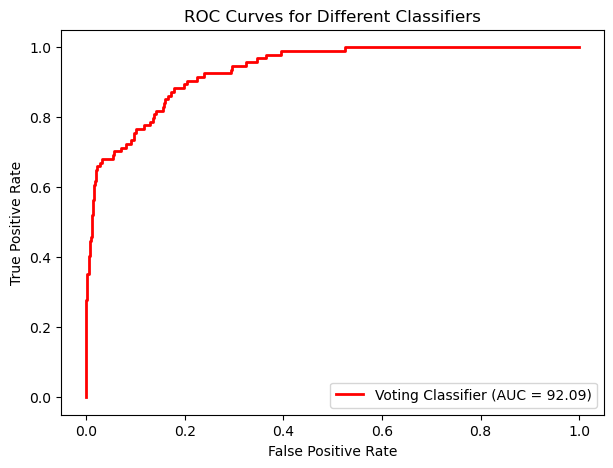

In [86]:
voting_auc = roc_auc_score(y_test, majority_voting.predict_proba(X_test)[:, 1])
fpr_voting, tpr_voting, _ = roc_curve(y_test, majority_voting.predict_proba(X_test)[:, 1])
plt.plot(fpr_voting, tpr_voting, color='red', lw=2, label='Voting Classifier (AUC = {:.2f})'.format(vacc*100))
# plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Different Classifiers')
plt.legend()
plt.show()

In [65]:
from sklearn.ensemble import StackingClassifier
base_models = [
    ('RandomForest', RandomForestClassifier()),
    ('KNN', KNeighborsClassifier()),
    ('SVC', SVC(probability=True)),
    ('LogisticRegression', LogisticRegression())
]
meta_model = LogisticRegression()
ensemble = StackingClassifier(estimators=base_models, final_estimator=meta_model)
ensemble.fit(X_train, y_train)

y_pred = ensemble.predict(X_test)
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_test, y_pred)
stacking_precision, stacking_recall, stacking_f1 = print_metrics('Stacking Classifier', y_test, ensemble.predict(X_test))
print("Accuracy of the Stacking Ensemble: {:.2f}%".format(accuracy * 100))
stacking_log_loss = log_loss(y_test, ensemble.predict_proba(X_test))
print('Log Loss :', stacking_log_loss)


Stacking Classifier Metrics:
Precision: 0.89
Recall: 0.53
F1 Score: 0.67
Accuracy of the Stacking Ensemble: 93.82%
Log Loss : 0.1902410352450113


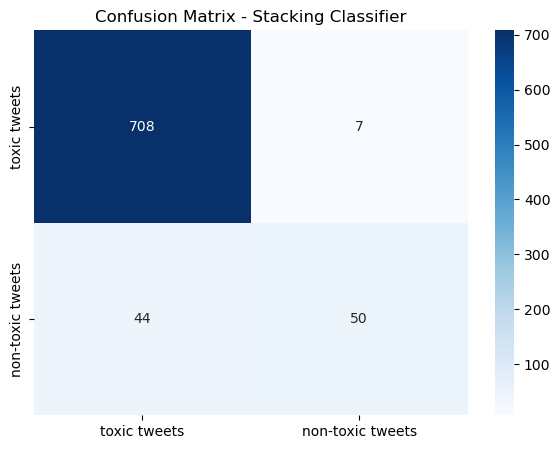

In [34]:
conf_matrix_stacking = confusion_matrix(y_test, ensemble.predict(X_test))
sns.heatmap(conf_matrix_stacking, annot=True, fmt='d', cmap='Blues', xticklabels=sentiments, yticklabels=sentiments)
plt.title('Confusion Matrix - Stacking Classifier')
plt.show()

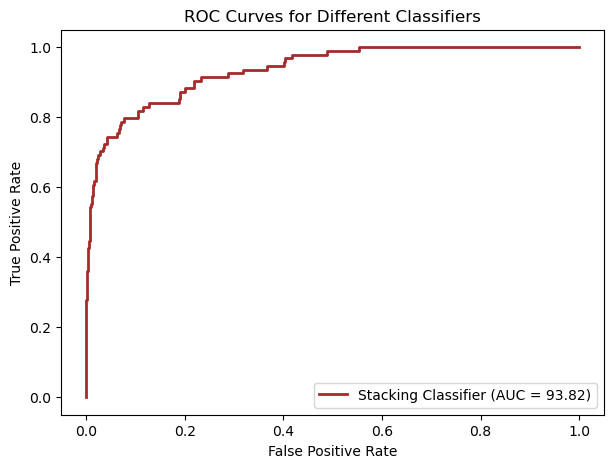

In [87]:
stacking_auc = roc_auc_score(y_test, ensemble.predict_proba(X_test)[:, 1])
fpr_stacking, tpr_stacking, _ = roc_curve(y_test, ensemble.predict_proba(X_test)[:, 1])
plt.plot(fpr_stacking, tpr_stacking, color='brown', lw=2, label='Stacking Classifier (AUC = {:.2f})'.format(accuracy*100))
# plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Different Classifiers')
plt.legend()
plt.show()

## Comparisions

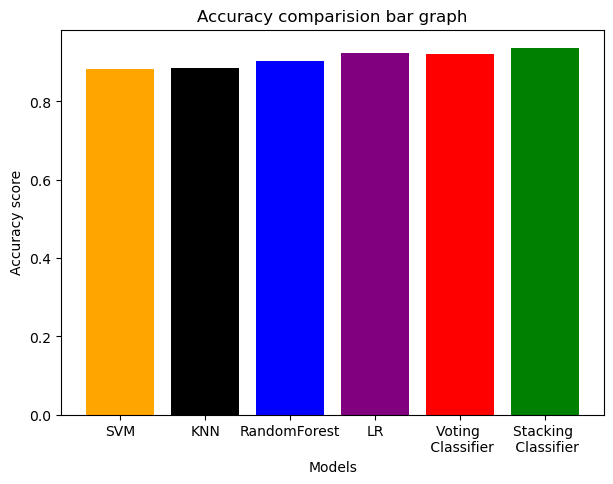

In [38]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams.update({'figure.figsize':(7,5), 'figure.dpi':100})
x=['SVM','KNN','RandomForest','LR','Voting \n Classifier','Stacking \n Classifier']
y = [svcacc,knnacc,racc,loacc,vacc,accuracy]
plt.bar(x,y,color=['orange', 'black', 'blue', 'purple', 'red','green'])
plt.xlabel('Models')
plt.ylabel("Accuracy score")
plt.title('Accuracy comparision bar graph')
plt.show()

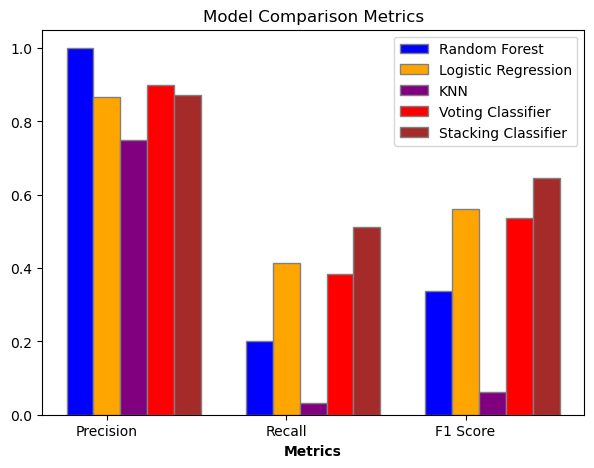

In [56]:
# Create a bar plot for comparison
metrics_names = ['Precision', 'Recall', 'F1 Score']
rf_metrics = [rf_precision, rf_recall, rf_f1]
# svc_metrics = [svc_precision, svc_recall, svc_f1]
lr_metrics = [lr_precision, lr_recall, lr_f1]
knn_metrics = [knn_precision, knn_recall, knn_f1]
voting_metrics = [voting_precision, voting_recall, voting_f1]
stacking_metrics = [stacking_precision, stacking_recall, stacking_f1]

barWidth = 0.15
r1 = np.arange(len(metrics_names))
# r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r1]
r4 = [x + barWidth for x in r3]
r5 = [x + barWidth for x in r4]
r6 = [x + barWidth for x in r5]

plt.bar(r1, rf_metrics, color='blue', width=barWidth, edgecolor='grey', label='Random Forest')
# plt.bar(r2, svc_metrics, color='green', width=barWidth, edgecolor='grey', label='SVC')
plt.bar(r3, lr_metrics, color='orange', width=barWidth, edgecolor='grey', label='Logistic Regression')
plt.bar(r4, knn_metrics, color='purple', width=barWidth, edgecolor='grey', label='KNN')
plt.bar(r5, voting_metrics, color='red', width=barWidth, edgecolor='grey', label='Voting Classifier')
plt.bar(r6, stacking_metrics, color='brown', width=barWidth, edgecolor='grey', label='Stacking Classifier')

plt.xlabel('Metrics', fontweight='bold')
plt.xticks([r + barWidth for r in range(len(metrics_names))], metrics_names)
plt.title('Model Comparison Metrics')
plt.legend()
plt.show()

## Testing

In [25]:
from sklearn.ensemble import VotingClassifier 


# comment2 = ["You are such a loser. Go kill yourself."]
# comment2 = ["Wow, you look so fat in that dress. Maybe you should try eating less"]
# comment2 = ["You are a disgrace to your race/gender/religion. You should be ashamed of yourself."]
# comment2 = ["You have no idea what you are talking about. You are just a stupid troll"]
comment2 = ["You're so stupid. You don't know anything about politics. You're just a brainwashed sheep who follows whatever the media tells you."]
# comment2 = ["nice video"]
      
check = count_vectorizer.transform(comment2).toarray() 

predicted_naive = majority_voting.predict(check)
print(predicted_naive)
if predicted_naive == 0:
   print("Non-Toxic comment")
elif predicted_naive == 1:
   print("Toxic comment ")


[1]
Toxic comment 
